Having already collected our data into CSV files, we now wish to create new ones with which we can perform our analysis. We will start by creating dataframes that hold all of the college and NFL statistics from each of the years we have information on. 

In [1]:
import pandas as pd
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Imports each year of college football statistics.
filenames = glob('data/College_FB_*.csv')
dataframes = []
for file in filenames:
    dataframes.append(pd.read_csv(file))

# Merges together all of the dataframes into one college dataframe. 
dataframes[0]['Year'] = '2009'
for i in range(1, len(dataframes)):
    dataframes[i]['Year'] = '20' + str(i+9)
college_fb_df = dataframes[0]
college_fb_df = np.vstack([college_fb_df, dataframes[1]])
for i in range(2,len(dataframes)):
    college_fb_df = np.vstack([college_fb_df, dataframes[i]])

college_fb_df = pd.DataFrame(college_fb_df, columns=dataframes[0].columns)
college_fb_df.head()

,Player,Team,Att,Gain,Loss,Yds,Avg,Lg,TD,Year
0,Toby Gerhart,STAN,343,1913,42,1871,5.45,--,28,2009
1,Ryan Mathews,FRES,276,1850,42,1808,6.55,--,19,2009
2,Dion Lewis,PITT,325,1862,63,1799,5.54,--,17,2009
3,Mark Ingram,ALA,271,1678,20,1658,6.12,--,17,2009
4,Ryan Williams,VT,293,1720,65,1655,5.65,--,21,2009


In [2]:
#Imports each year of NFL statistics.
filenames = glob('data/NFL_Pro_*.csv')
dataframes = []
for file in filenames:
    dataframes.append(pd.read_csv(file))

# Merges together all of the dataframes into one NFL dataframe. 
for i in range(0, len(dataframes)):
    dataframes[i]['Year'] = '20' + str(i+10)
nfl_fb_df = dataframes[0]
nfl_fb_df = np.vstack([nfl_fb_df, dataframes[1]])
for i in range(2,len(dataframes)):
    nfl_fb_df = np.vstack([nfl_fb_df, dataframes[i]])

nfl_fb_df = pd.DataFrame(nfl_fb_df, columns=dataframes[0].columns)
nfl_fb_df.head()

,Rk,Player,Team,Pos,Att,Att/G,Yds,Avg,Yds/G,TD,Long,1st Downs,1st Down %,20+,40+,FUM,Year
0,1,Arian Foster,HOU,RB,327,20.4,"1,616",4.9,101,16,74T,89,27.2,12,3,3,2010
1,2,Maurice Jones-Drew,JAC,RB,299,21.4,"1,324",4.4,94.6,5,37,75,25.1,8,0,2,2010
2,3,Jamaal Charles,KC,RB,230,14.4,"1,467",6.4,91.7,5,80,70,30.4,10,3,2,2010
3,4,Darren McFadden,OAK,RB,223,17.2,"1,157",5.2,89,7,57T,45,20.2,14,4,3,2010
4,5,Adrian Peterson,MIN,RB,283,18.9,"1,298",4.6,86.5,12,80T,70,24.7,9,2,1,2010


Now that we have imported all of our data, we need to make sure that we can interact with it properly. Specifically, we need to make sure our numeric columns have numbers and not strings. 

In [3]:
# Transform our numeric columns from strings into floats. 
nfl_fb_df['Yds'] = nfl_fb_df['Yds'].str.replace(',','')
for col in nfl_fb_df.columns:
    if col not in ['Player','Team','Pos','Long']:
        nfl_fb_df[col] = nfl_fb_df[col].astype('float')

for col in college_fb_df.columns:
    if col not in ['Player','Team','Pos','Lg']:
        college_fb_df[col] = college_fb_df[col].astype('float')

Before we create our averages for college football players, we want to make sure we only include players who have graduated before the start of the 2016 NFL season (as that is the last season we have data on). Fortunately, we have information on players who were still playing in college in 2016, so we can use that information to omit the proper names.

In [4]:
clg_fb_not_done = college_fb_df[college_fb_df.Year == 2016]
college_fb_df = college_fb_df[college_fb_df.Year <= 2015]
drop_players = clg_fb_not_done['Player'].tolist()
college_fb_df = college_fb_df[~college_fb_df['Player'].isin(drop_players)]
len(college_fb_df)

632

For our data analysis, it will be most useful to use the college and NFL averages for the players. This is more useful than cumulative career statistics because there are naturally players in our data who are still in the middle of their career. 

In [5]:
# Create dataframes for career averages.
college_avgs = college_fb_df.groupby(by='Player').mean()
nfl_avgs = nfl_fb_df.groupby(by='Player').mean()

# We delete the year columns because they are no longer important or useful.
del nfl_avgs['Year']
del college_avgs['Year']

Now that we have obtained our averages, we should visualize our information.

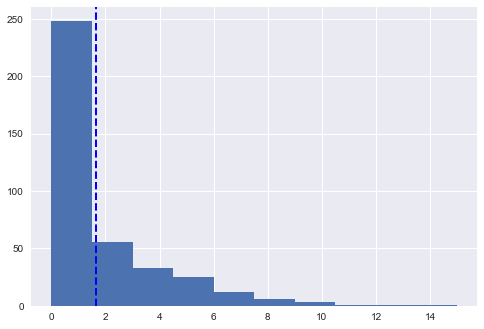

In [6]:
plt.hist(nfl_avgs['TD'], bins = 10)
plt.axvline(nfl_avgs['TD'].mean(), color='b', linestyle='dashed', linewidth=2)

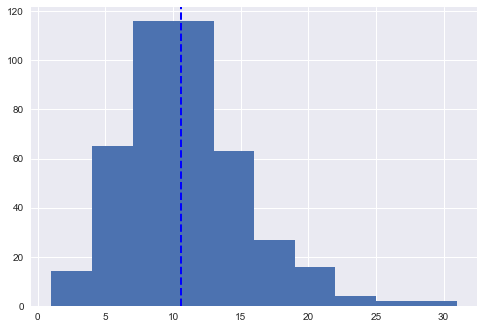

In [7]:
plt.hist(college_avgs['TD'], bins = 10)
plt.axvline(college_avgs['TD'].mean(), color='b', linestyle='dashed', linewidth=2)

Surprisingly, the NFL average on touchdowns (and most of the statistics) is low, with a majority of players below the average. The college averages, on the other hand, seem to resemble a bell curve much more closely. 

Now lets take a look at how many of our college players actually made it into the NFL. 

In [8]:
college_avgs.shape

(425, 6)

In [9]:
nfl_avgs.shape

(386, 12)

In [10]:
# Creates a column for the averages to be merged on.
college_avgs['Player'] = college_avgs.index
nfl_avgs['Player'] = nfl_avgs.index

avgs_merged = pd.merge(college_avgs, nfl_avgs, on='Player', suffixes=['_College','_Pro'], how='inner')
avgs_merged.shape

(145, 19)

This innner join tells us a couple of things. 

The first thing it tells us is that of the 425 college running backs that we have information on, only 145 of them made it to the NFL, which is roughly 34.1%. This also tells us that from our 386 NFL players, we only have college information on 145 of them, which means we only have college statistics on roughly 37.6% of our NFL players. This may be due to information collected on older players who were playing in college before 2009. For example, Adrian Peterson played college football in 2004, so he is no a member of our inner join. Keeping this in mind, some of our college football data may be incomplete/incorrect if some of the earlier years were omitted, for example if a player's senior year was in 2009 and so we have missed out on their prior years.

We will now look at a pair plot of the information to determine if we can discover any trends that lead to college players making it into the NFL.

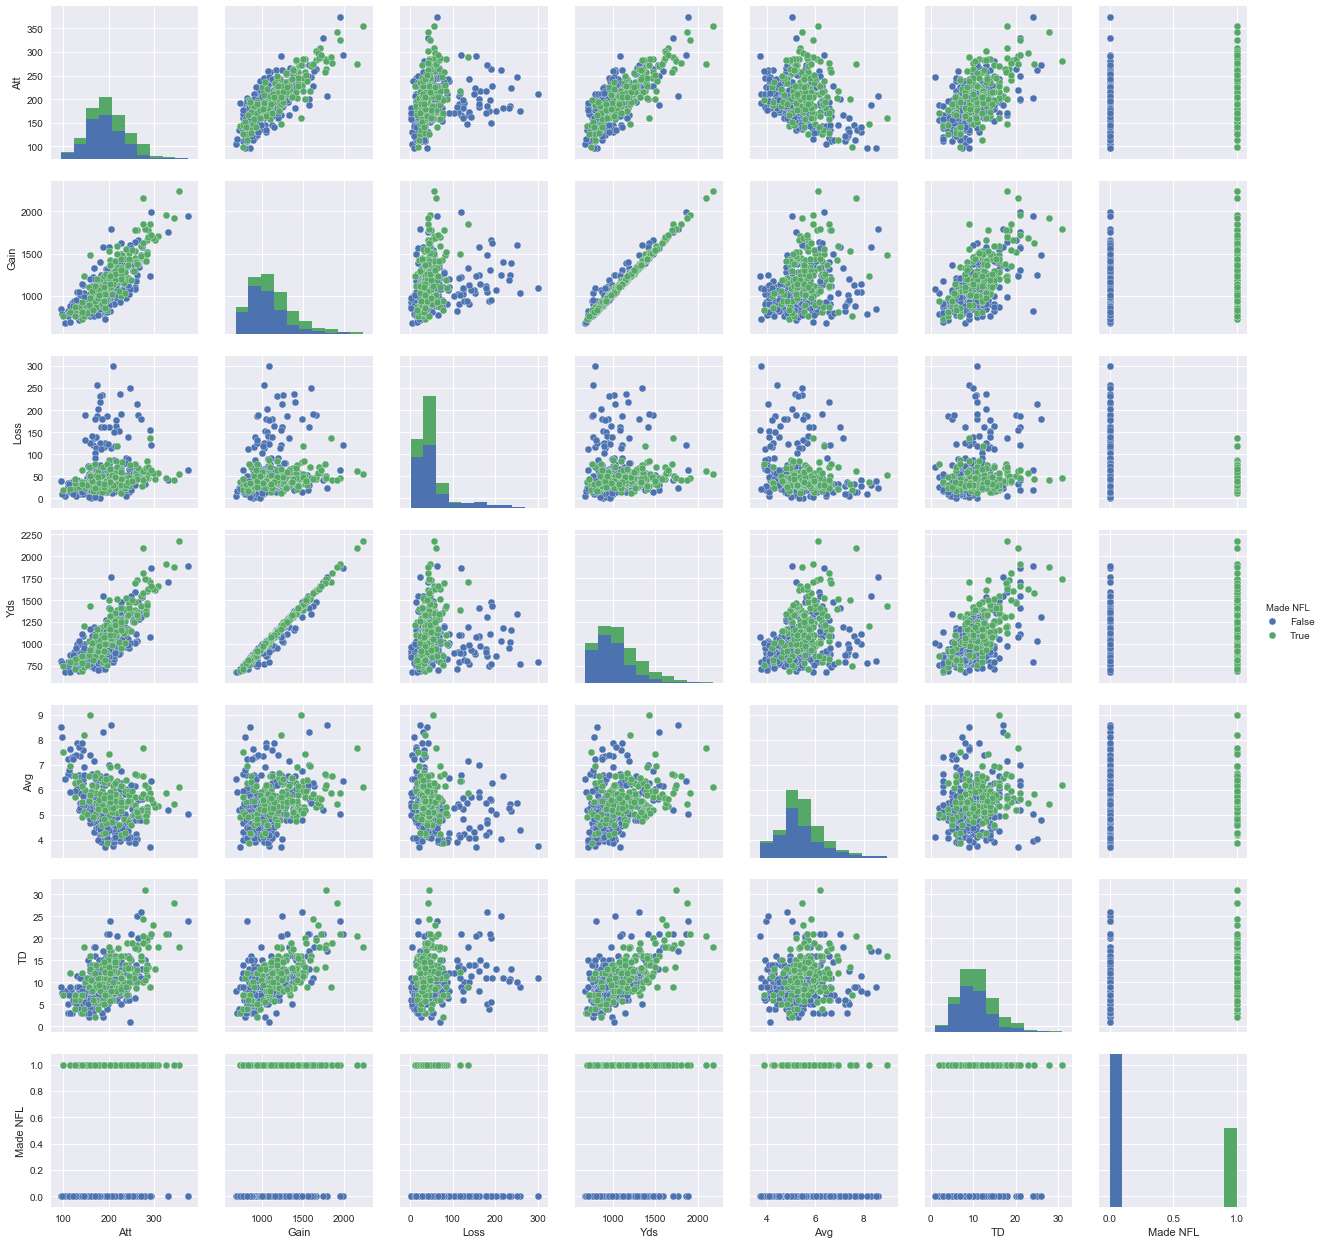

In [11]:
college_avgs['Made NFL'] = college_avgs['Player'].isin(avgs_merged['Player'].values.tolist())
sns.pairplot(college_avgs, hue='Made NFL')

The only noticable trend is that when a player has a large amount of negative (loss) yards in college, that player does not make it into the NFL. This is not a surprising result, as we would expect players who have a negative impact more frequently than others to not make it into the NFL. Hopefully our machine learning algorithms will uncover some less obvious trends. 

Finally, we should make sure to save our new dataframes as CSV files.

In [12]:
college_avgs.to_csv('college_avgs_clean.csv', index=False)
nfl_avgs.to_csv('nfl_avgs_clean.csv', index=False)
avgs_merged.to_csv('avgs_merged_clean.csv', index=False)